<a href="https://colab.research.google.com/github/VandhanaV/Richetors-predictor-/blob/master/RP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import files
#import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pylab
%matplotlib inline
import seaborn as sns
from google.colab import drive
import pandas_profiling 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score,accuracy_score, recall_score, f1_score,roc_auc_score,classification_report,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import kurtosis



In [ ]:
#pd.read_csv(io.BytesIO(uploaded1['train_labels.csv']))
train_label = pd.read_csv("https://raw.githubusercontent.com/VandhanaV/Richetors-predictor-/master/train_labels.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/VandhanaV/Richetors-predictor-/master/test_values.csv")
train_feat = pd.read_csv("https://raw.githubusercontent.com/VandhanaV/Richetors-predictor-/master/train_values.csv")

In [ ]:
train_feat.set_index('building_id',inplace=True)
train_label.set_index('building_id',inplace=True)
df=pd.concat([train_feat,train_label], axis=1, join='inner')

### Basic check

In [ ]:
mem = df.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   79.52911376953125 MB


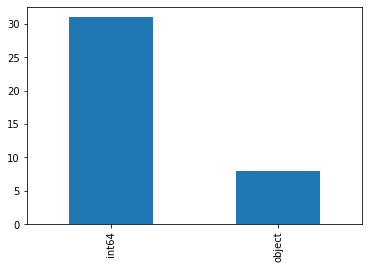

In [ ]:
pp = pd.value_counts(df.dtypes)
pp.plot.bar()
plt.show()

In [ ]:
df.head().T

building_id,802906,28830,94947,590882,201944
geo_level_1_id,6,8,21,22,11
geo_level_2_id,487,900,363,418,131
geo_level_3_id,12198,2812,8973,10694,1488
count_floors_pre_eq,2,2,2,2,3
age,30,10,10,10,30
area_percentage,6,8,5,6,8
height_percentage,5,7,5,5,9
land_surface_condition,t,o,t,t,t
foundation_type,r,r,r,r,r
roof_type,n,n,n,n,n


In [ ]:
def null_check(df):
  for column in df.columns:
    if(df[column].isnull().sum()!=0):
      print("Percentage of missing values in {} type {} is: {:.2f}".format(column,df[column].dtype, (df[column].isnull().sum()*100)/len(df)))
    else:
      break
#df.isnull().values.any()

In [ ]:
null_check(df)

In [ ]:
num_des=df.describe().T
#add more cols
#num_des['type']=num_des

In [ ]:
des=df.describe(include='object').T
des['top %'] = des['freq'].apply(lambda x:round((x/len(df))*100,2))
des

,count,unique,top,freq,top %
land_surface_condition,260601,3,t,216757,83.18
foundation_type,260601,5,r,219196,84.11
roof_type,260601,3,n,182842,70.16
ground_floor_type,260601,5,f,209619,80.44
other_floor_type,260601,4,q,165282,63.42
position,260601,4,s,202090,77.55
plan_configuration,260601,10,d,250072,95.96
legal_ownership_status,260601,4,v,250939,96.29


### dist

In [ ]:
#divide the columns into three types

bin_cols=[col for col in train_feat.select_dtypes(exclude='object') if np.isin(train_feat[col].unique(), [0, 1]).all()]
cat_cols=df.select_dtypes(include='object').columns.tolist()
non_bin_cols=[col for col in train_feat.select_dtypes(exclude='object') if np.logical_not(np.isin(train_feat[col].unique(), [0, 1])).any()]
cat_cols

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

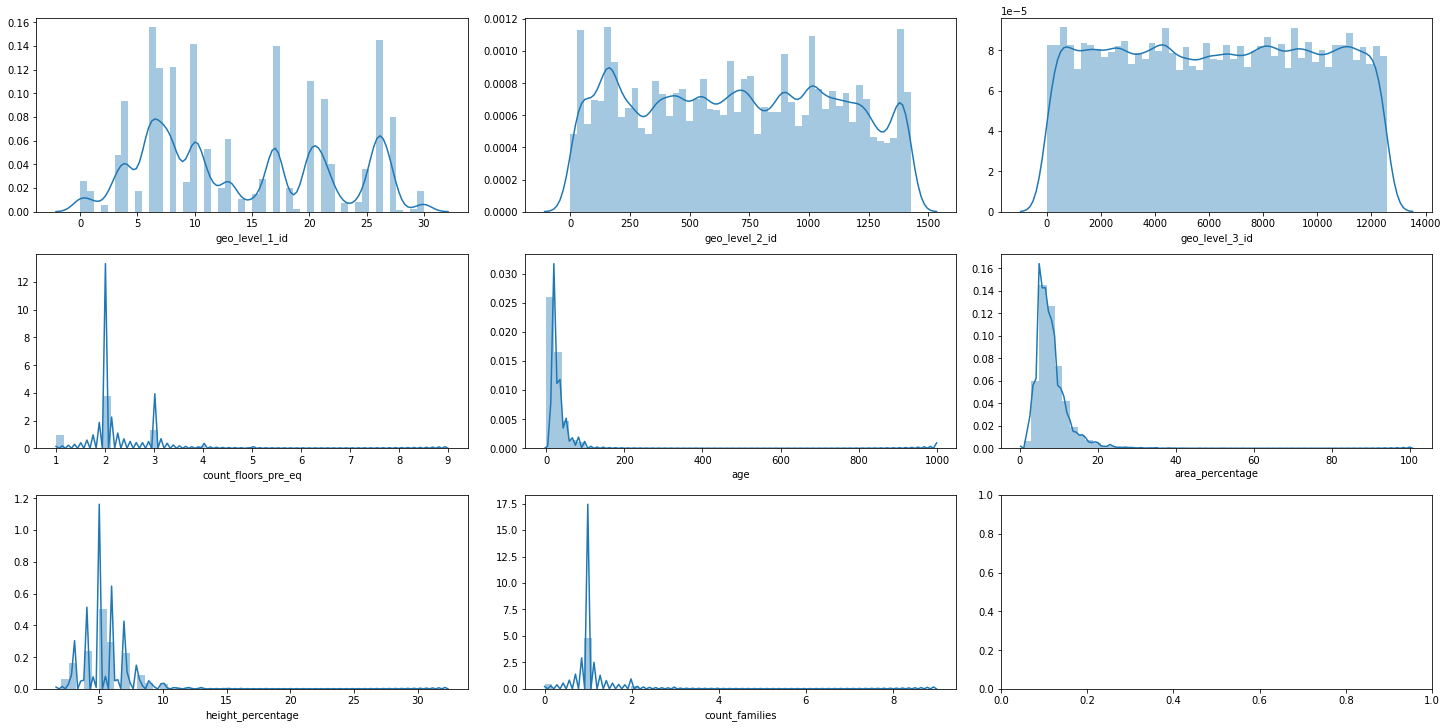

In [ ]:
#distribution plot of numeric except binary variables

fig, axes = plt.subplots(math.ceil(len(non_bin_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten()
for ax,col in zip(axes,non_bin_cols):
        sns.distplot(df[col],ax=ax)

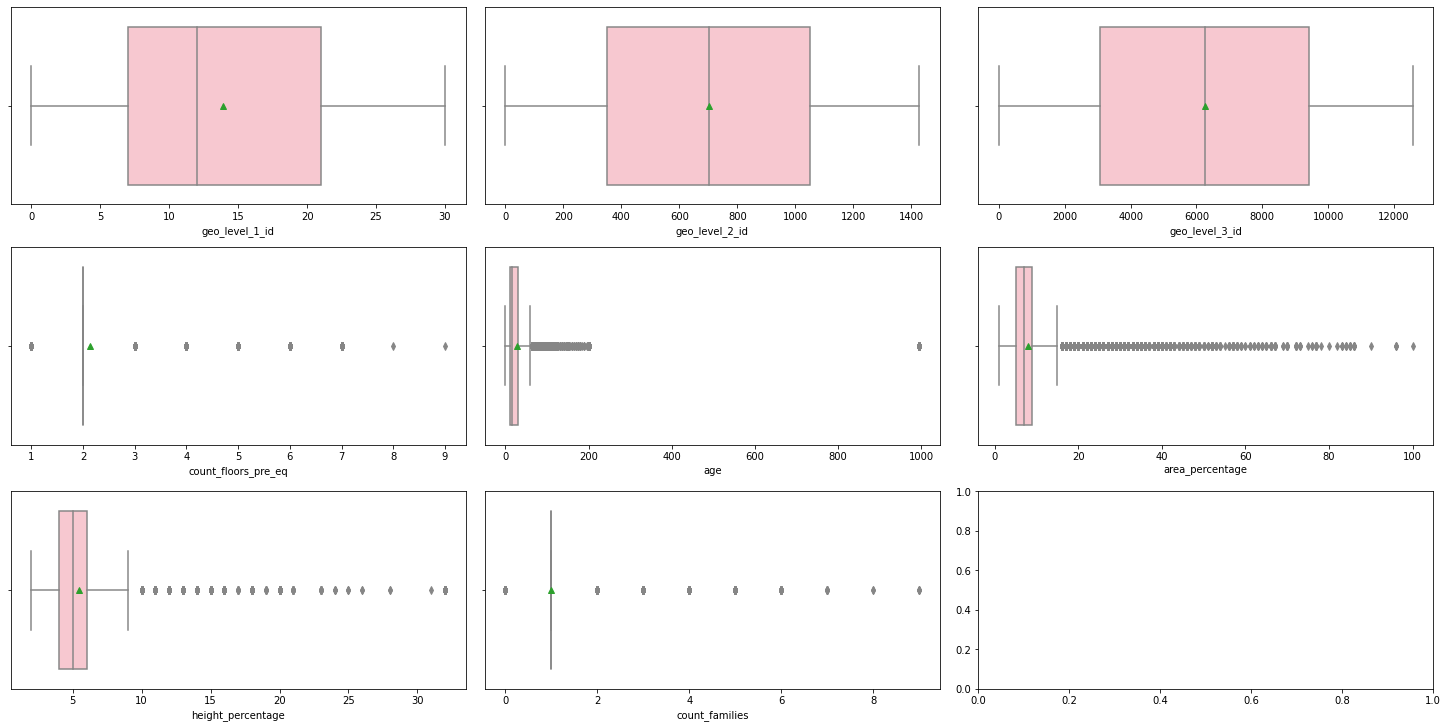

In [ ]:
fig, axes = plt.subplots(math.ceil(len(non_bin_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten() 

for ax,col in zip(axes,non_bin_cols):
    sns.boxplot(df[col],ax=ax,color='pink',showmeans=True)


In [ ]:
for col in (cat_cols):
  display(df[col].value_counts())
  print("*"*70)

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64

**********************************************************************


r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

**********************************************************************


n    182842
q     61576
x     16183
Name: roof_type, dtype: int64

**********************************************************************


f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: int64

**********************************************************************


q    165282
x     43448
j     39843
s     12028
Name: other_floor_type, dtype: int64

**********************************************************************


s    202090
t     42896
j     13282
o      2333
Name: position, dtype: int64

**********************************************************************


d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64

**********************************************************************


v    250939
a      5512
w      2677
r      1473
Name: legal_ownership_status, dtype: int64

**********************************************************************


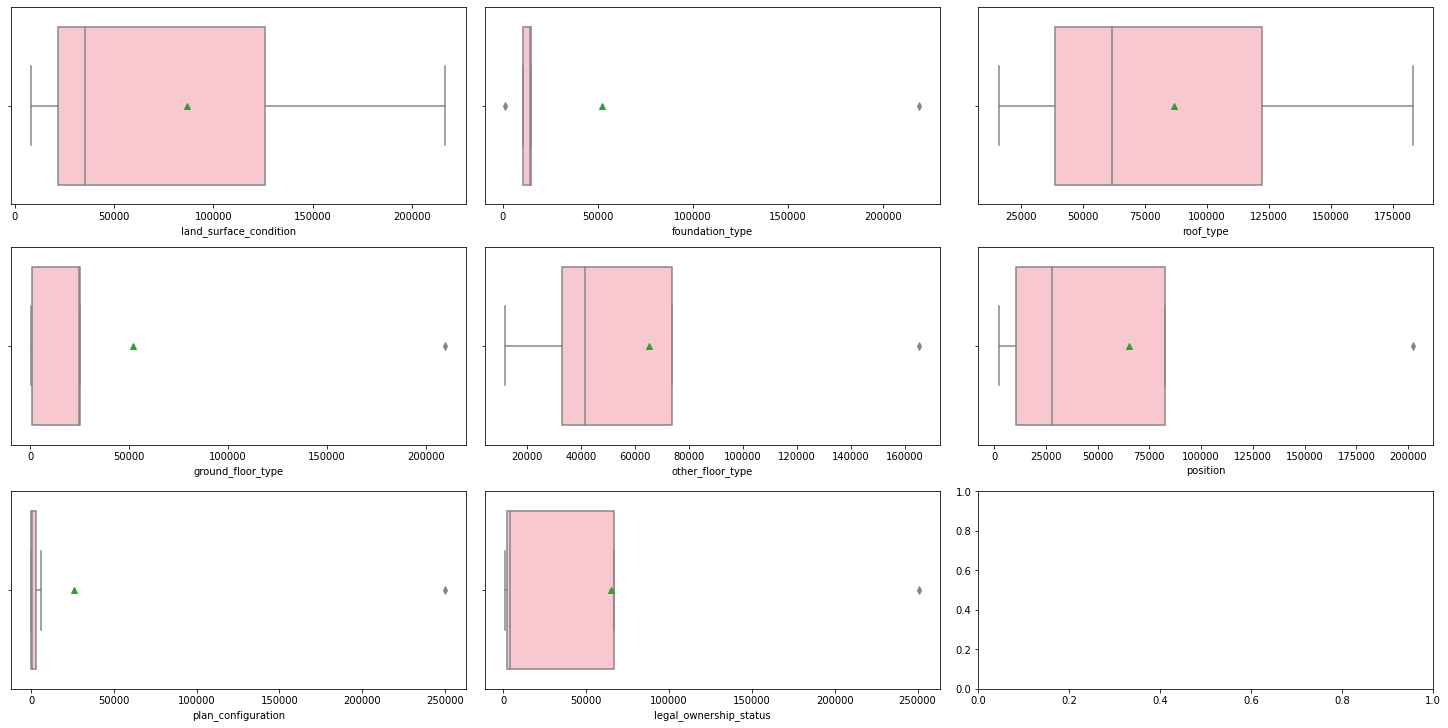

In [ ]:
fig, axes = plt.subplots(math.ceil(len(cat_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten() 

for ax,col in zip(axes,cat_cols):
    sns.boxplot(df[col].value_counts(),ax=ax,color='pink',showmeans=True)


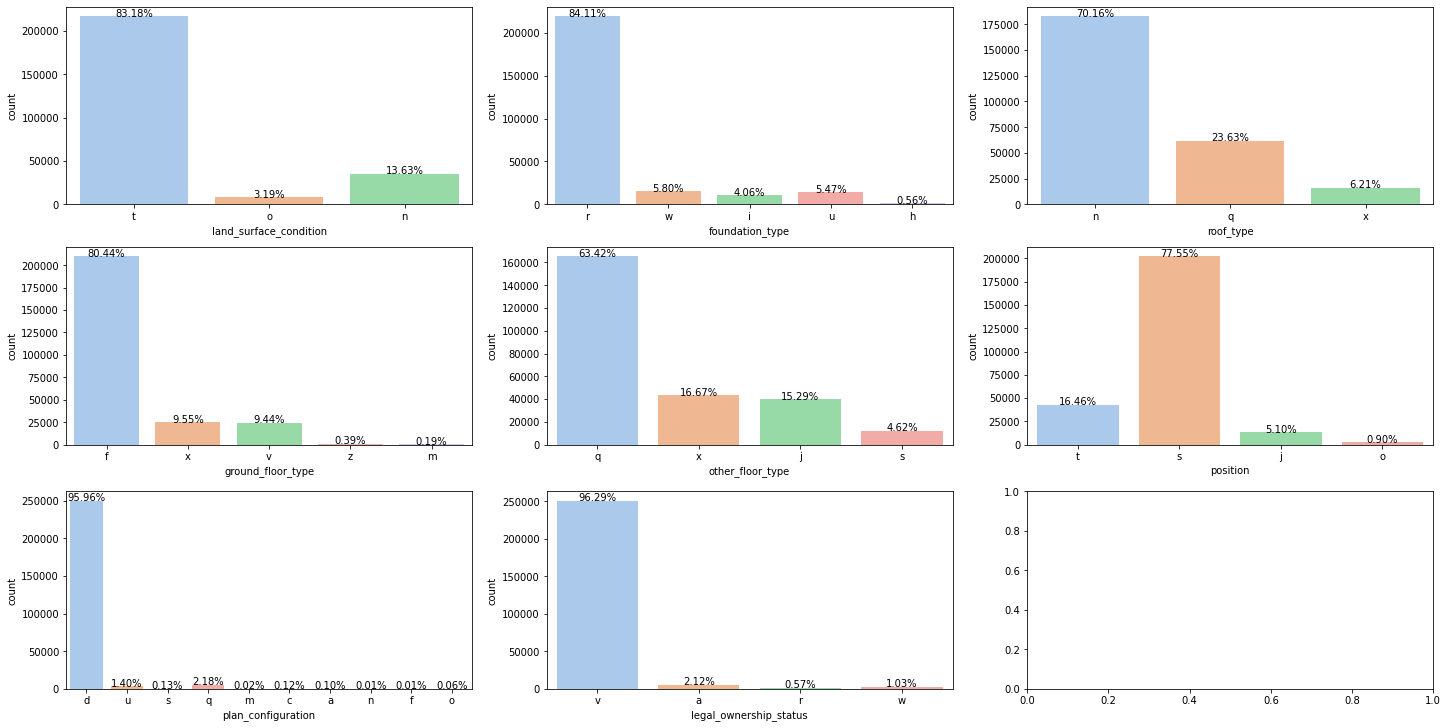

In [ ]:
fig, axes = plt.subplots(math.ceil(len(cat_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten() 

for ax,col in zip(axes,cat_cols):
    total=len(df[col])
    sns.countplot(df[col],ax=ax,palette='pastel')
    for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

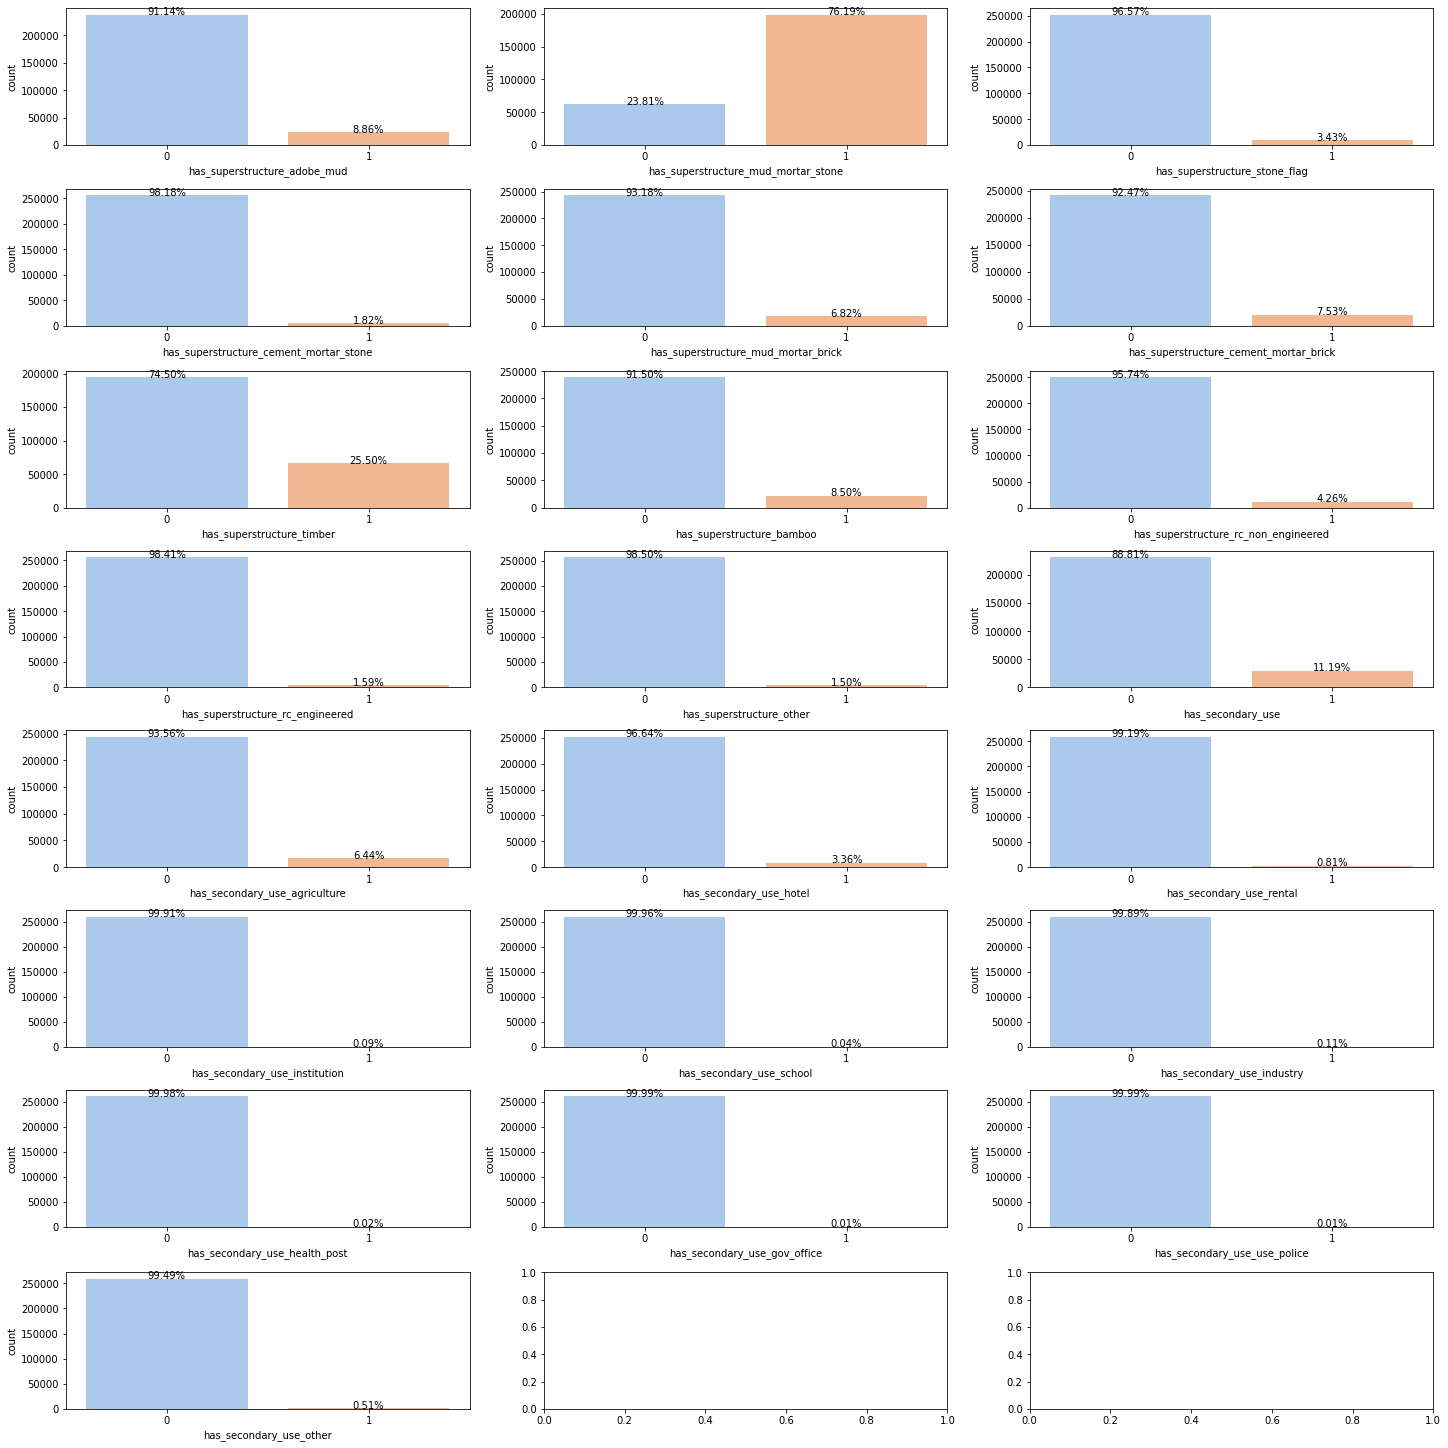

In [ ]:
fig, axes = plt.subplots(math.ceil(len(bin_cols) / 3), 3,constrained_layout=True, figsize=(20, 20))
axes = axes.flatten() 

for ax,col in zip(axes,bin_cols):
    total=len(df[col])
    sns.countplot(df[col],ax=ax,palette='pastel')
    for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

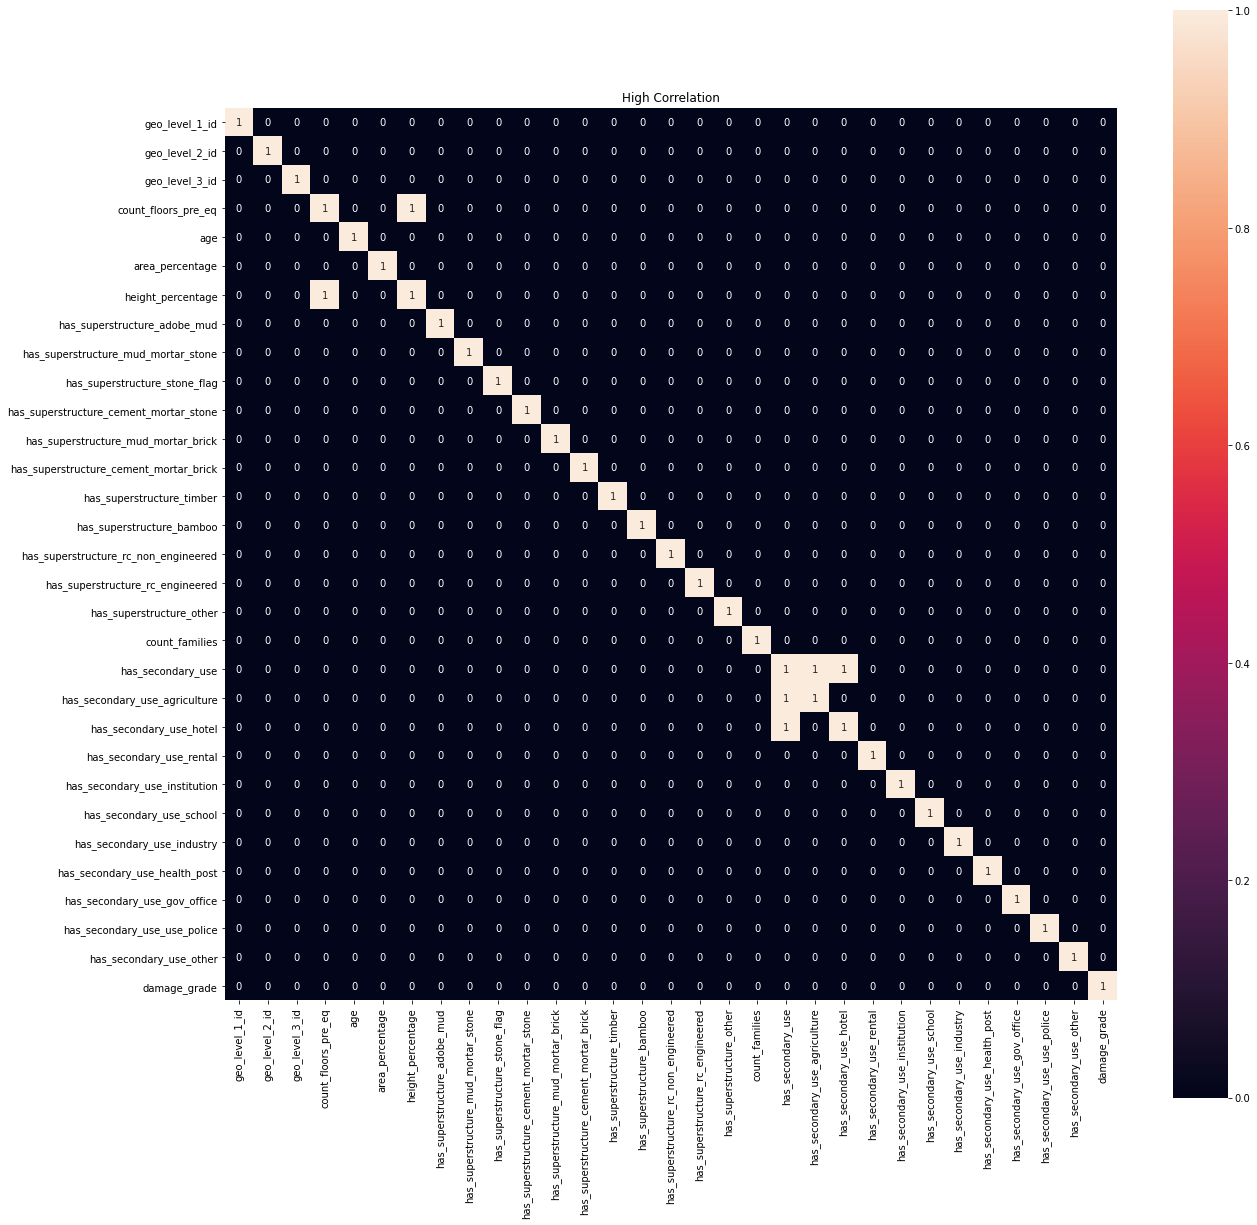

In [ ]:
#corrected axis issue in heatmap
#plt.figure(figsize=(20,20))
#ax = sns.heatmap(df.corr(), annot=True, fmt='.2f') #notation: "annot" not "annote"
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.figure(figsize=(20,20))
plt.title('High Correlation')
sns.heatmap(df.corr() > 0.5, annot=True, square=True)

(31.5, -0.5)

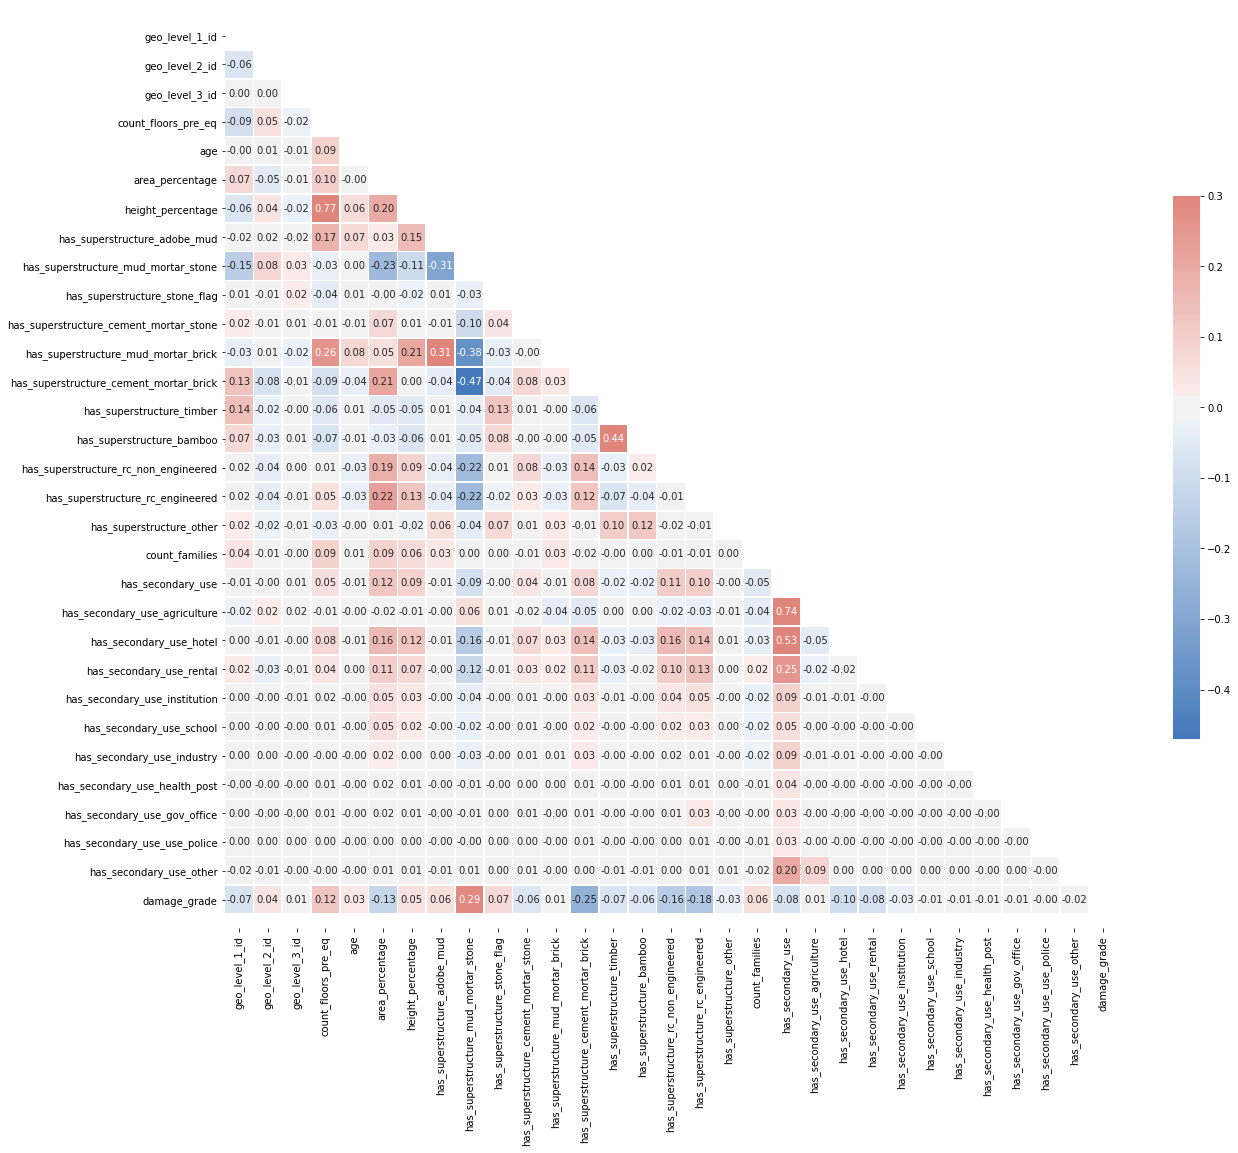

In [ ]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

###Correlation

floor count and height +ve cor, height can be removed after feat eng
SS_mud_mortar_stone +ve cor with target and SS_cement_mortar_brick -ve cor with target

SS_mud_mortar_brick +ve with floor count, can be indication of strong foundation
SS_rc +ve with area





distribution of numeric columns with target

fig, axes = plt.subplots(math.ceil(len(non_bin_cols) / 3), 3,constrained_layout=True, figsize=(20, 10))
axes = axes.flatten()
for ax,col in zip(axes,non_bin_cols):
  sns.boxplot(df[col],y=df['damage_grade'],ax=ax)

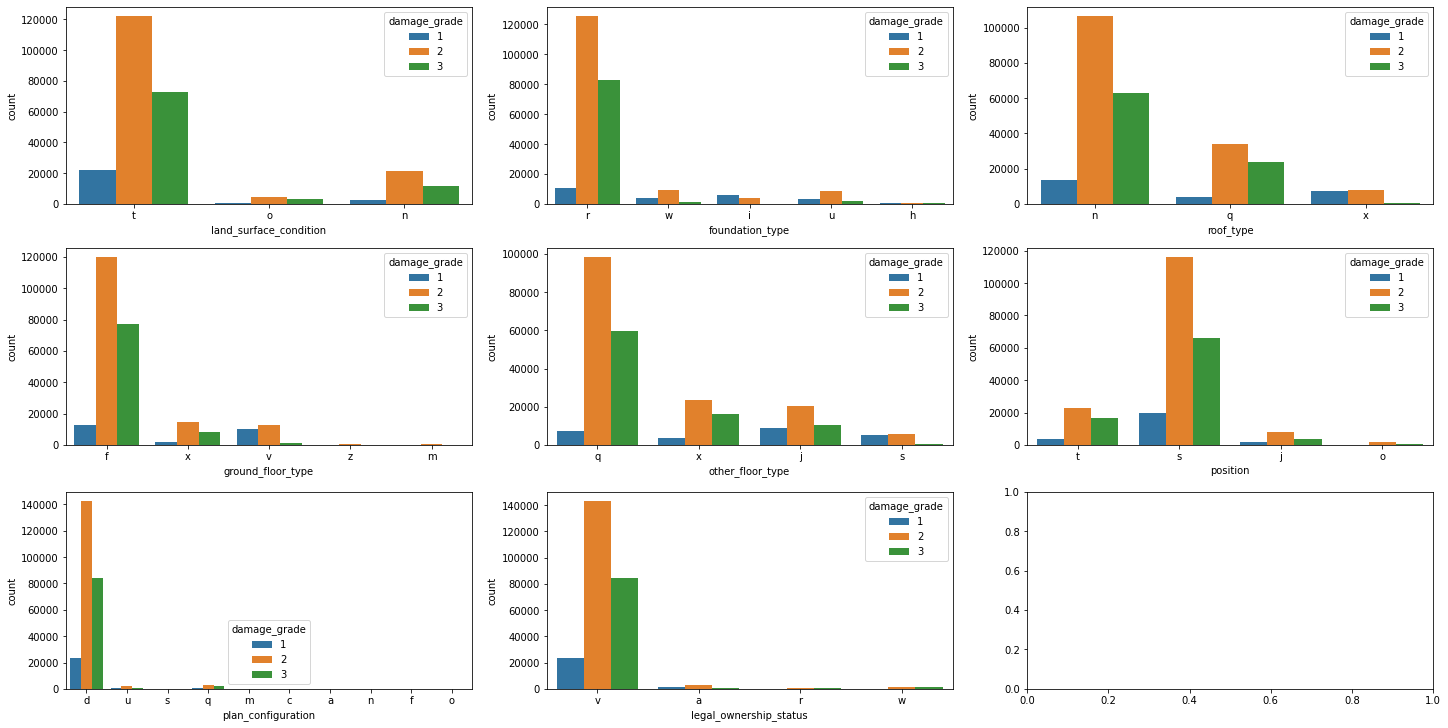

In [ ]:
fig,axes=plt.subplots(math.ceil(len(cat_cols)/3),3,constrained_layout=True,figsize=(20,10))
ax=axes.flatten()
for ax,col in zip(ax,cat_cols):
  sns.countplot(df[col],hue=df['damage_grade'],ax=ax)

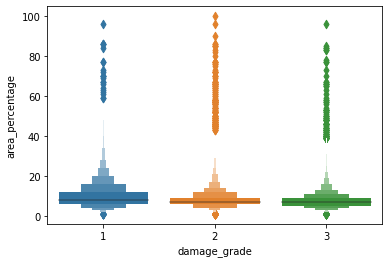

In [ ]:
sns.boxenplot(df['damage_grade'],df['area_percentage'])

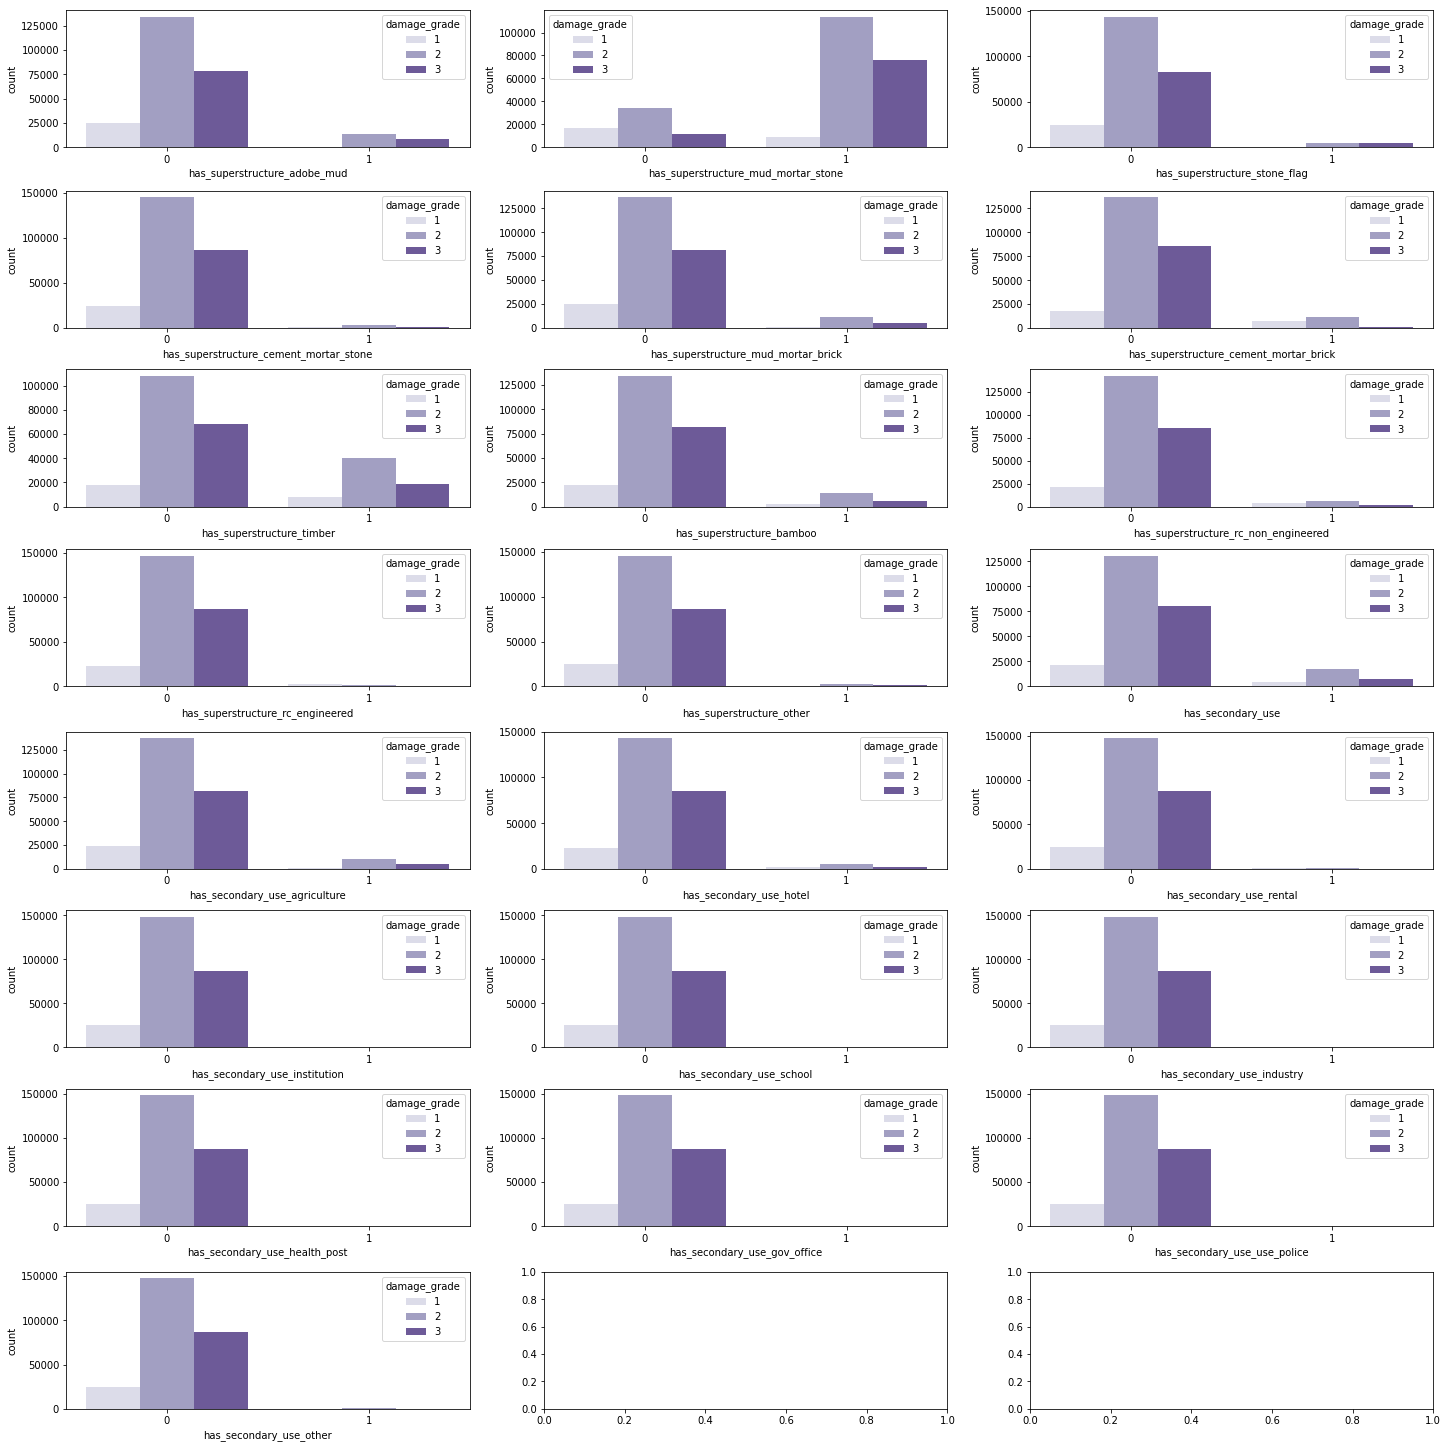

In [ ]:
fig,axes=plt.subplots(math.ceil(len(bin_cols)/3),3,constrained_layout=True,figsize=(20,20))
ax=axes.flatten()
for ax,col in zip(ax,bin_cols):
  sns.countplot(df[col],hue=df['damage_grade'],ax=ax,palette = 'Purples')
#Every dist has damage 2 as the most count


In [ ]:
#group of geo level 1
df.groupby(['geo_level_1_id']).count()['damage_grade'].sort_values(ascending=False)

geo_level_1_id
6     24381
26    22615
10    22079
17    21813
8     19080
7     18994
20    17216
21    14889
4     14568
27    12532
13     9608
11     8220
3      7540
22     6252
25     5624
16     4332
0      4011
9      3958
12     3194
18     3189
1      2701
5      2690
30     2686
15     2320
14     1714
24     1310
23     1121
2       931
29      396
19      372
28      265
Name: damage_grade, dtype: int64

In [ ]:
#group of geo level 2
df.groupby(['geo_level_2_id','geo_level_1_id']).count()['damage_grade'].sort_values(ascending=False).head(60)

geo_level_2_id  geo_level_1_id
39              26                4038
158             20                2520
181             27                2080
1387            3                 2040
157             7                 1897
363             21                1760
463             8                 1740
673             6                 1704
533             27                1684
883             11                1626
1394            27                1537
548             27                1497
1006            3                 1450
720             3                 1359
991             26                1145
1001            26                1135
889             25                1114
765             11                1091
1253            6                 1090
1155            27                1069
1401            26                1063
886             26                1053
151             10                1043
660             11                1041
131             11               

In [ ]:
#group of geo level 3
df.groupby(['geo_level_3_id','geo_level_2_id','geo_level_1_id']).count()['damage_grade'].sort_values(ascending=False).head(60)

geo_level_3_id  geo_level_2_id  geo_level_1_id
633             39              26                651
9133            39              26                647
621             158             20                530
11246           39              26                470
2005            39              26                466
11440           39              26                455
7723            151             10                443
9229            158             20                381
2452            158             20                349
12258           1001            26                312
8236            463             8                 303
10445           39              26                302
6626            1001            26                283
2170            991             26                283
2537            363             21                259
85              39              26                252
406             1166            7                 251
6973            463             8  

### Feature engineering


In [ ]:

def feat_total(data,type):
  if type=='ss':
    df_ss = data.iloc[:,14:25]
    data = pd.concat([data,pd.DataFrame(df_ss.sum(axis=1),columns=['SS_total'])],axis=1)
  else:
    df_sec = df.iloc[:,28:38]
    data = pd.concat([data,pd.DataFrame(df_sec.sum(axis=1),columns=['sec_total'])],axis=1)
  return data

In [ ]:
df = feat_total(df,'ss')
df = feat_total(df,'sec')
df.columns

             geo_level_1_id  geo_level_2_id  ...  damage_grade  SS_total
building_id                                  ...                        
802906                    6             487  ...             3         2
28830                     8             900  ...             2         1
94947                    21             363  ...             3         1
590882                   22             418  ...             2         3
201944                   11             131  ...             3         1

[5 rows x 40 columns]


Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
     

1    176016
2     57838
3     20210
4      4925
5      1259
6       314
7        35
8         4
Name: SS_total, dtype: int64

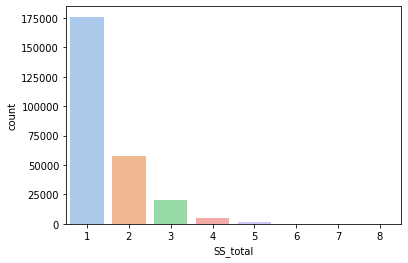

In [ ]:
#add value for each column
sns.countplot(df['SS_total'],palette='pastel')
df['SS_total'].value_counts()

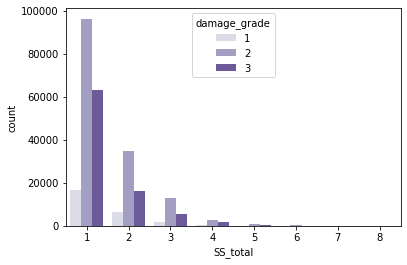

In [ ]:
sns.countplot(df['SS_total'],hue=df['damage_grade'],palette='Purples')

In [ ]:
#df.plot('sec_total','has_secondary_use',kind='bar')

In [ ]:
#melt_df=pd.melt(df.iloc[:, list(range(3)) + [-1]].head(10),id_vars='damage_grade',var_name='geo_level')
#melt_df.groupby(['damage_grade'])[['geo_level','value']].groups
#sns.swarmplot(x='geo_level_1_id', data=df.head(50), y='damage_grade')
#melt_df  

In [ ]:
t=pd.melt(df.iloc[:,14:25].head(30).reset_index(),id_vars='building_id',var_name='SS')
t[t['value']==1].sort_values('building_id')
t.groupby(['building_id'])[['SS','value']].agg(np.sum)
#try with target

,value
building_id,
7962,2
28830,1
94947,1
201944,1
219578,2
287845,2
333020,1
354011,1
433870,1


### Normalization

In [ ]:
for col in bin_cols+non_bin_cols:
  print(col)
  print("Skew: %f" % df[col].skew())
  print("Kurtosis: %f" % kurtosis(df[col],fisher = False ))

has_superstructure_adobe_mud
Skew: 2.894530
Kurtosis: 9.378208
has_superstructure_mud_mortar_stone
Skew: -1.230040
Kurtosis: 2.512980
has_superstructure_stone_flag
Skew: 5.114983
Kurtosis: 27.162746
has_superstructure_cement_mortar_stone
Skew: 7.201350
Kurtosis: 52.858851
has_superstructure_mud_mortar_brick
Skew: 3.427233
Kurtosis: 12.745792
has_superstructure_cement_mortar_brick
Skew: 3.219832
Kurtosis: 11.367196
has_superstructure_timber
Skew: 1.124293
Kurtosis: 2.264020
has_superstructure_bamboo
Skew: 2.975932
Kurtosis: 9.856067
has_superstructure_rc_non_engineered
Skew: 4.530387
Kurtosis: 21.524167
has_superstructure_rc_engineered
Skew: 7.750517
Kurtosis: 61.069829
has_superstructure_other
Skew: 7.984432
Kurtosis: 64.750424
has_secondary_use
Skew: 2.462560
Kurtosis: 7.064134
has_secondary_use_agriculture
Skew: 3.549955
Kurtosis: 13.602038
has_secondary_use_hotel
Skew: 5.174349
Kurtosis: 27.773584
has_secondary_use_rental
Skew: 10.975365
Kurtosis: 121.457243
has_secondary_use_instit

### Test data wrangaling

In [ ]:
#drive.mount('/drive')
#test.to_csv('/drive/My Drive/Colab Notebooks/Submission_file.csv',index=False)


In [ ]:
def test_process(data,model):
  #Test label encoding
  encoder = LabelEncoder()
  for col in cat_cols:
    data[col] = encoder.fit_transform(data[col])
  data.set_index('building_id',inplace=True)
  data['damage_grade']=model.predict(data)
  df_test.reset_index(inplace=True)
  test=df_test[['building_id','damage_grade']]
  test.to_csv('Submission_file.csv',index=False)
  #files.download('Submission_file.csv')
  print("Submission file created with columns", test.columns)

### Model building

In [ ]:
X=df.drop(columns='damage_grade')
#y=df.iloc[:,-1:]
y=df['damage_grade']

In [ ]:
#label encoding
encoder = LabelEncoder()
for col in cat_cols:
    X[col] = encoder.fit_transform(X[col])

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42,test_size =0.2)

In [ ]:
#Basic logreg model
logreg=LogisticRegression(max_iter=10000,solver='sag')
#logreg.fit(X_train,y_train)
#y_pred=logreg.predict(X_test)
#print(logreg.score(X_test,y_test))
#print("Micro f1 = " , f1_score(y_test,y_pred,average='micro'))

#### Random forest

In [ ]:
rf_clf=RandomForestClassifier(n_estimators=100,n_jobs=100,random_state=0)
rf_clf.fit(X_train,y_train)
y_pred=rf_clf.predict(X_test)
print("Random forest Micro f1 = " , f1_score(y_test,y_pred,average='micro'))

Micro f1 =  0.7177529210874697


#### Xgboost

XGboost Micro f1 =  0.6739126263885957


<function matplotlib.pyplot.show>

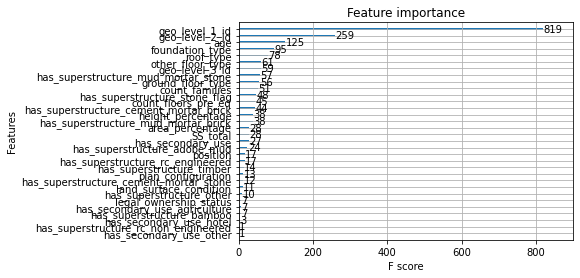

In [ ]:
from xgboost import plot_importance
from xgboost import XGBClassifier

xgb_clf=XGBClassifier(random_state=0)
xgb_clf.fit(X_train,y_train)
y_pred=xgb_clf.predict(X_test)
print("XGboost Micro f1 = " , f1_score(y_test,y_pred,average='micro'))

plot_importance(xgb_clf)
plt.show

#### catboost

In [ ]:
from catboost import CatBoostRegressor
categorical_features_indices = np.where(X.dtypes != np.float)[0]
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5924361	test: 0.5964702	best: 0.5964702 (0)	total: 233ms	remaining: 11.4s
1:	learn: 0.5765121	test: 0.5801746	best: 0.5801746 (1)	total: 381ms	remaining: 9.14s
2:	learn: 0.5633149	test: 0.5666934	best: 0.5666934 (2)	total: 485ms	remaining: 7.6s
3:	learn: 0.5521388	test: 0.5552484	best: 0.5552484 (3)	total: 590ms	remaining: 6.79s
4:	learn: 0.5419708	test: 0.5446615	best: 0.5446615 (4)	total: 738ms	remaining: 6.64s
5:	learn: 0.5336306	test: 0.5359247	best: 0.5359247 (5)	total: 838ms	remaining: 6.14s
6:	learn: 0.5266664	test: 0.5287485	best: 0.5287485 (6)	total: 944ms	remaining: 5.8s
7:	learn: 0.5200864	test: 0.5218051	best: 0.5218051 (7)	total: 1.04s	remaining: 5.48s
8:	learn: 0.5146893	test: 0.5160941	best: 0.5160941 (8)	total: 1.15s	remaining: 5.24s
9:	learn: 0.5097571	test: 0.5110327	best: 0.5110327 (9)	total: 1.25s	remaining: 5.02s
10:	learn: 0.5056928	test: 0.5066944	best: 0.5066944 (10)	total: 1.36s	remaining: 4.82s
11:	learn: 0.5022015	test: 0.5029390	best: 0.5029390 (

In [ ]:
y_pred=model.predict(X_test)
y_pred=y_pred.astype(np.int)
print("Catboost Micro f1 = " , f1_score(y_test,y_pred,average='micro'))

Catboost Micro f1 =  0.48797989294142474


### Other


In [ ]:
cat={'land_surface_condition':1,
 'foundation_type':2,
 'roof_type':3,
 'ground_floor_type':4,
 'other_floor_type':5,
 'position':6,
 'plan_configuration':7,
 'legal_ownership_status':8}
plt.figure(figsize=(20,10))
for variable,i in cat.items():
  plt.subplot(5,3,i)
  sns.boxplot(df[variable].value_counts(),whis=1.5)
  plt.title(variable)

In [ ]:
fig,axes=plt.subplots(math.ceil(len(cat_cols)/3),3,constrained_layout=True,figsize=(20,10))
ax=axes.flatten()
for ax,col in zip(ax,cat_cols):
  sns.countplot(df[col],hue=df['damage_grade'],ax=ax)

In [ ]:
ax_height=sns.distplot(df['height_percentage'],color='b',hist=False)
ax_area=sns.distplot(df['area_percentage'],color='g',hist=False)